In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

## Dependencies

In [2]:
!pip install --quiet efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import math, os, re, warnings, random, time
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, Sequential, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping
import efficientnet.tfkeras as efn
import cv2

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

SEED = 0
seed_everything(SEED)
warnings.filterwarnings('ignore')

### Hardware configuration

Note that we have `32` cores, this is because the `TPU v2 Pod` have more cores than a single `TPU v3` which has `8` cores.

In [4]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [5]:
BATCH_SIZE = 8 * REPLICAS
LEARNING_RATE = 1e-5 * REPLICAS
EPOCHS = 10 #default 10
HEIGHT = 512
WIDTH = 512
HEIGHT_RS = 512
WIDTH_RS = 512
CHANNELS = 3
N_CLASSES = 5
N_FOLDS = 5
FOLDS_USED = 5
ES_PATIENCE = 5 #default 5
T1=0.75 #tempered-loss t1
T2=2.07 #tempered-loss t2
CUTMIX_PROB=0.2

# Load data

In [6]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


database_base_path = '/kaggle/input/cassaba-clean-noisy-tfrec/'
train = pd.read_csv(f'{database_base_path}clean_data.csv')
print(f'Train samples: {len(train)}')

# GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification') # Original dataset
#GCS_PATH = KaggleDatasets().get_gcs_path(f'cassaba-clean-noisy-tfrec') #
GCS_PATH = 'gs://casds/cassaba-clean-noisy-tfrec'
print(GCS_PATH)

# FILENAMES_COMP = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/*.tfrec') # Original TFRecords
FILENAMES_COMP = tf.io.gfile.glob(GCS_PATH + '/*train*.tfrec')
print(FILENAMES_COMP)
TRAINING_FILENAMES = FILENAMES_COMP
NOISE_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/*noisy*.tfrec')
print(NOISE_FILENAMES)
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

Train samples: 24225
gs://casds/cassaba-clean-noisy-tfrec
['gs://casds/cassaba-clean-noisy-tfrec/Id_train00-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train01-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train02-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train03-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train04-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train05-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train06-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train07-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train08-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train09-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train10-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train11-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train12-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train13-1615.tfrec', 'gs://casds/cassaba-clean-noisy-tfrec/Id_train14-1615.tfrec']
['gs://casd

,image_id,label,source,fold,is_noisy,class,file
0,1000015157.jpg,0,2020,3,False,Cassava Bacterial Blight,13
1,1000201771.jpg,3,2020,2,False,Cassava Mosaic Disease,14
2,1000723321.jpg,1,2020,1,False,Cassava Brown Streak Disease,3
3,1000812911.jpg,3,2020,1,False,Cassava Mosaic Disease,11
4,1000837476.jpg,3,2020,0,False,Cassava Mosaic Disease,11


# Augmentation

In [7]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label


def cutmix(image, label, proba=1.0):
    '''cutmix augmentation
    proba: cutmixを行う確率:0~1
    '''
    dim = HEIGHT #height
    imgs=[]
    labels=[]
    
    for img1_idx in range(BATCH_SIZE):
        # cutmix を行うかどうか
        p = tf.cast(tf.random.uniform([], 0, 1) <= proba, tf.int32)
        
        # img1 とmixするimage
        img2_idx = tf.cast(tf.random.uniform([],0,BATCH_SIZE), tf.int32)
        
        x = tf.cast(tf.random.uniform([],0,dim), tf.int32)
        y = tf.cast(tf.random.uniform([],0,dim), tf.int32)
        b = tf.random.uniform([],0,1) #mix ratio
        
        #切り取り領域
        w = tf.cast(dim*tf.math.sqrt(1-b), tf.int32) * p
        ya = tf.math.maximum(0, y-w//2)
        yb = tf.math.maximum(dim, y+w//2)
        xa = tf.math.maximum(0, x-w//2)
        xb = tf.math.maximum(dim, x+w//2)
        
        # img1, img2の混合
        one = image[img1_idx, ya:yb, 0:xa,:]
        two = image[img2_idx, ya:yb, xa:xb,:]
        three = image[img1_idx, ya:yb, xb:dim,:]
        middle = tf.concat([one,two,three], axis=1) #width方向に連結
        img = tf.concat([image[img1_idx, 0:ya, :, :],
                         middle,
                         image[img2_idx, yb:dim, :, :]
                        ], axis=0) #height方向に連結
        imgs.append(img)

        # label mix
        a = tf.cast(w*w/dim/dim, tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[img1_idx], N_CLASSES)
            lab2 = tf.one_hot(label[img2_idx], N_CLASSES)
        else:
            lab1 = label[img1_idx, ]
            lab2 = label[img2_idx, ]
        labels.append((1-a)*lab1 + a*lab2)
        
    # reshape
#     print(labels)
#     print(tf.stack(labels))
    image2 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,dim,dim,3))
    label2 = tf.reshape(tf.stack(labels),(BATCH_SIZE,N_CLASSES))
    return image2, label2

## Auxiliary functions

In [8]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

In [9]:
# Datasets utility functions
def decode_image(image_data):
    """
        Decode a JPEG-encoded image to a uint8 tensor.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

def scale_image(image, label):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT_RS, WIDTH_RS])
    image = tf.reshape(image, [HEIGHT_RS, WIDTH_RS, 3])
    return image, label

def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'label': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_id': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['label'], tf.int32)
        # One-Hot Encoding needed to use "categorical_crossentropy" loss
        label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), N_CLASSES)
    else:
        label_or_name = example['image_id']
    return image, label_or_name

def get_dataset(FILENAMES, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(FILENAMES)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    
    # cutmix
#     if augment:
#         dataset = dataset.map(partial(cutmix, proba=CUTMIX_PROB), num_parallel_calls=AUTO)

    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset


def unfreeze_model(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, L.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
                
def unfreeze_block(model, block_name=None, n_top=3):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers[:-n_top]:
        if isinstance(layer, L.BatchNormalization):
            layer.trainable = False
        else:
            if block_name and (block_name in layer.name):
                layer.trainable = True

In [10]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', 
                  fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    labels = np.argmax(labels, axis=-1)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(label, str(correct), ', shoud be ' if not correct else '',
                                correct_label if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Model evaluation
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1, sharex='col', figsize=(20, 8))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best', fontsize=16)
    axes[0].set_title('Loss')
    axes[0].axvline(np.argmin(history['loss']), linestyle='dashed')
    axes[0].axvline(np.argmin(history['val_loss']), linestyle='dashed', color='orange')
    
    axes[1].plot(history['accuracy'], label='Train accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation accuracy')
    axes[1].legend(loc='best', fontsize=16)
    axes[1].set_title('Accuracy')
    axes[1].axvline(np.argmax(history['accuracy']), linestyle='dashed')
    axes[1].axvline(np.argmax(history['val_accuracy']), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# Training data samples (with augmentation)

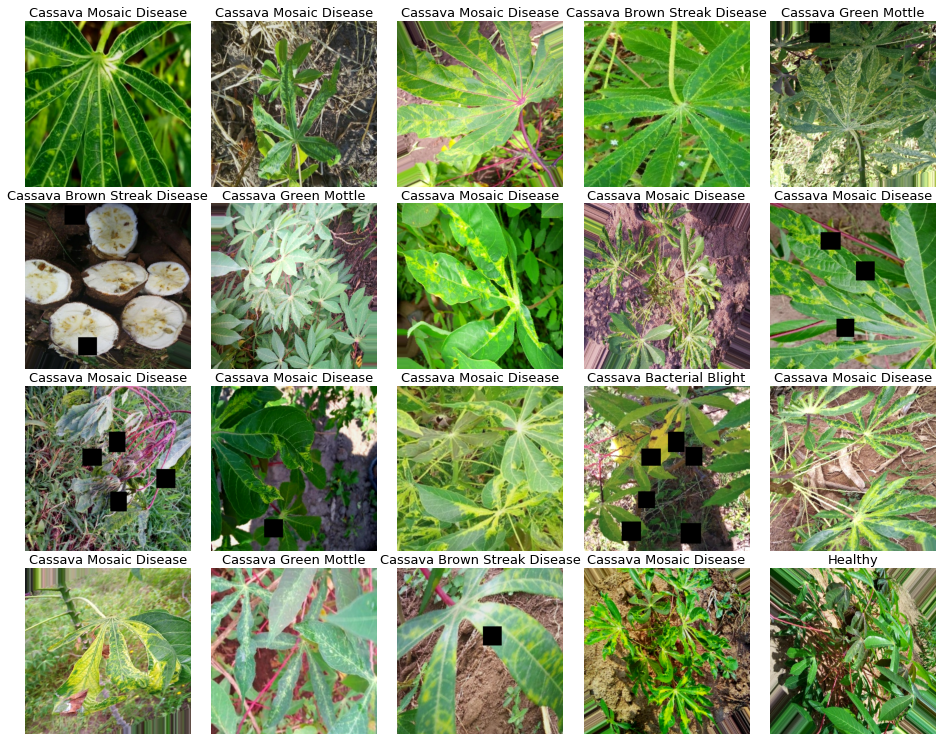

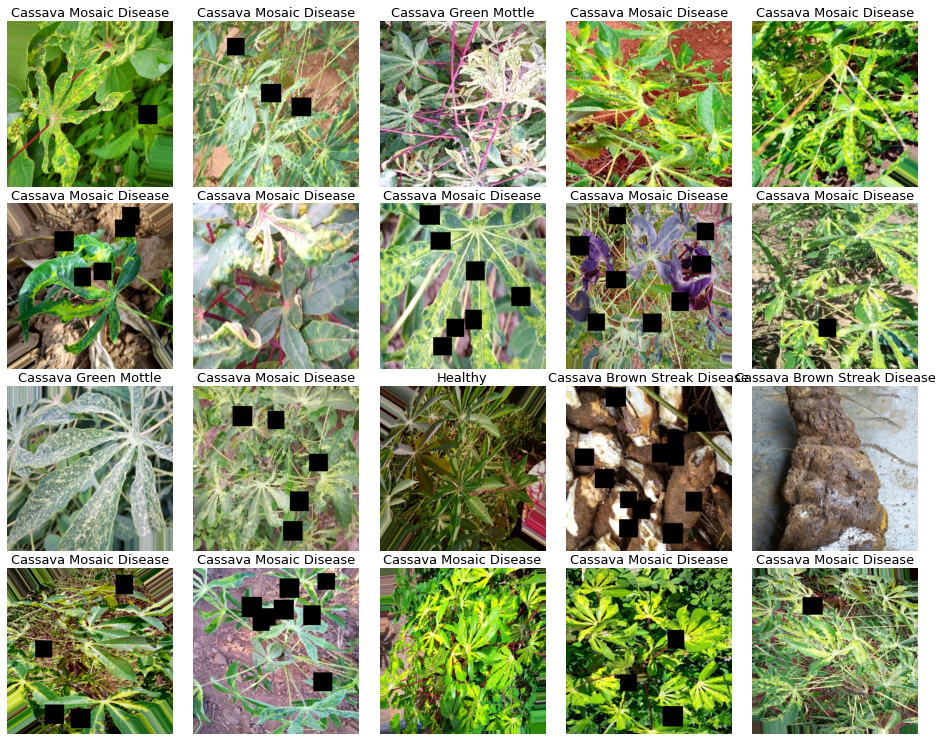

In [11]:
train_dataset = get_dataset(FILENAMES_COMP, ordered=True, augment=True)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

### Learning rate schedule

We are going to use a `cosine learning rate schedule with a warm-up phase`, this may be a good idea since we are using a pre-trained model, the warm-up phase will be useful to avoid the pre-trained weights degradation resulting in catastrophic forgetting, during the schedule the learning rate will slowly decrease to very low values, this helps the model to land on more stable weights.

In [12]:
lr_start = 1e-8
lr_min = 1e-8
lr_max = LEARNING_RATE
num_cycles = 1.
warmup_epochs = 1
hold_max_epochs = 0
total_epochs = EPOCHS
warmup_steps = warmup_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)
total_steps = total_epochs * (NUM_TRAINING_IMAGES//BATCH_SIZE)

@tf.function
def lrfn(step):
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, float(lr))

    return lr


# # rng = [i for i in range(total_epochs)]
# rng = [i for i in range(total_steps)]
# y = [lrfn(tf.cast(x, tf.float32)) for x in rng]

# sns.set(style='whitegrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

# print(f'{total_steps} total steps and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
# print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Model

In [13]:
def model_fn(input_shape, N_CLASSES):
    inputs = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB4(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')
    base_model.trainable = False

    x = L.Dropout(.25)(base_model.output)
    output = L.Dense(N_CLASSES, activation='softmax', name='output')(x)
    model = Model(inputs=inputs, outputs=output)

    return model


# Training

In [14]:
#EPOCHS=1
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
oof_pred = []; oof_labels = []; history_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if fold >= FOLDS_USED:
        break
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    FILENAMES_COMP = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
    TRAIN_FILENAMES = FILENAMES_COMP    
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAIN_FILENAMES)
    
    ct_train = count_data_items(TRAIN_FILENAMES)
    ct_valid = count_data_items(VALID_FILENAMES)
    
    step_size = (ct_train // BATCH_SIZE)
    valid_step_size = (ct_valid // BATCH_SIZE)
    total_steps=(total_epochs * step_size)
    warmup_steps=(warmup_epochs * step_size)

    ## MODEL
    K.clear_session()
    with strategy.scope():
        model_path = f'model_{fold}.h5'
        model = model_fn((None, None, CHANNELS), N_CLASSES)
        unfreeze_model(model) # unfreeze all layers except "batch normalization"
        
        optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)))
        loss_fn = losses.CategoricalCrossentropy(label_smoothing=0.3)
        #loss_fn = bi_tempered_logistic_loss
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
        cbs = [
               EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=ES_PATIENCE, restore_best_weights=True)
              ]
        tra_ds = get_dataset(TRAIN_FILENAMES, labeled=True, ordered=False, repeated=True, augment=True)
        val_ds = get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False, augment=False)
        history = model.fit(tra_ds, batch_size=BATCH_SIZE, epochs=EPOCHS,
                            steps_per_epoch=step_size,
                            validation_data=val_ds,
                            validation_steps=valid_step_size,
                            callbacks=cbs
                           ).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

    # Load best model weights
    model.load_weights(model_path)

    
    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False, augment=False)
    oof_labels.append([target.numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, image_name: image)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))
    
    ## RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_accuracy']):.3f}")


FOLD: 1
TRAIN: [ 0  2  3  4  5  7  9 10 11 12 13 14] VALID: [1 6 8]
71680000/71678424 [==============================] - 1s 0us/step
Epoch 1/10
302/302 [==============================] - 183s 358ms/step - loss: 1.3388 - accuracy: 0.5919 - val_loss: 0.9956 - val_accuracy: 0.9092
Epoch 2/10
302/302 [==============================] - 91s 301ms/step - loss: 1.0083 - accuracy: 0.9022 - val_loss: 0.9701 - val_accuracy: 0.9273
Epoch 3/10
302/302 [==============================] - 91s 300ms/step - loss: 0.9748 - accuracy: 0.9285 - val_loss: 0.9561 - val_accuracy: 0.9394
Epoch 4/10
302/302 [==============================] - 86s 287ms/step - loss: 0.9703 - accuracy: 0.9291 - val_loss: 0.9471 - val_accuracy: 0.9442
Epoch 5/10
302/302 [==============================] - 88s 292ms/step - loss: 0.9565 - accuracy: 0.9430 - val_loss: 0.9459 - val_accuracy: 0.9469
Epoch 6/10
302/302 [==============================] - 86s 284ms/step - loss: 0.9515 - accuracy: 0.9468 - val_loss: 0.9440 - val_accuracy: 0.

## Model loss graph


FOLD: 1


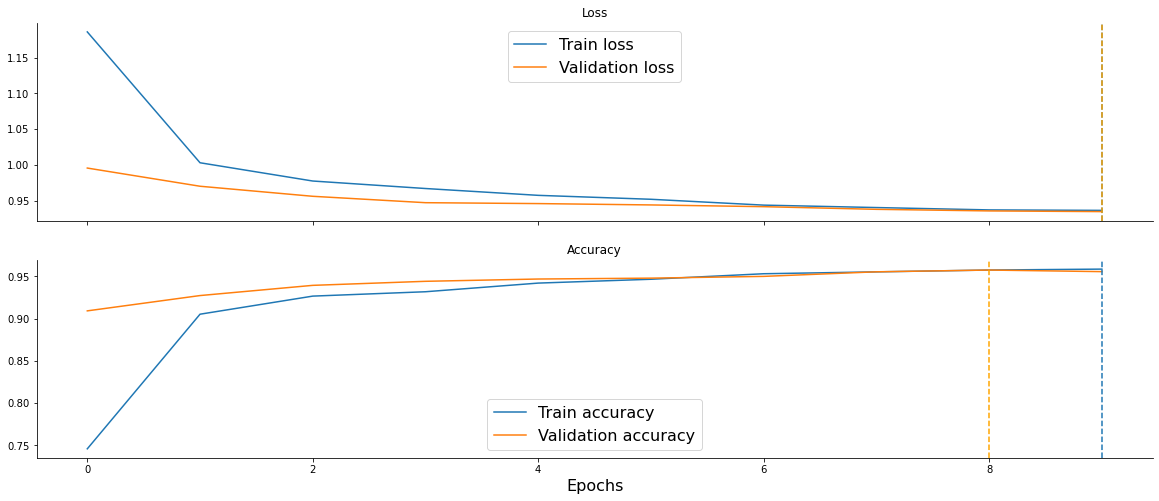


FOLD: 2


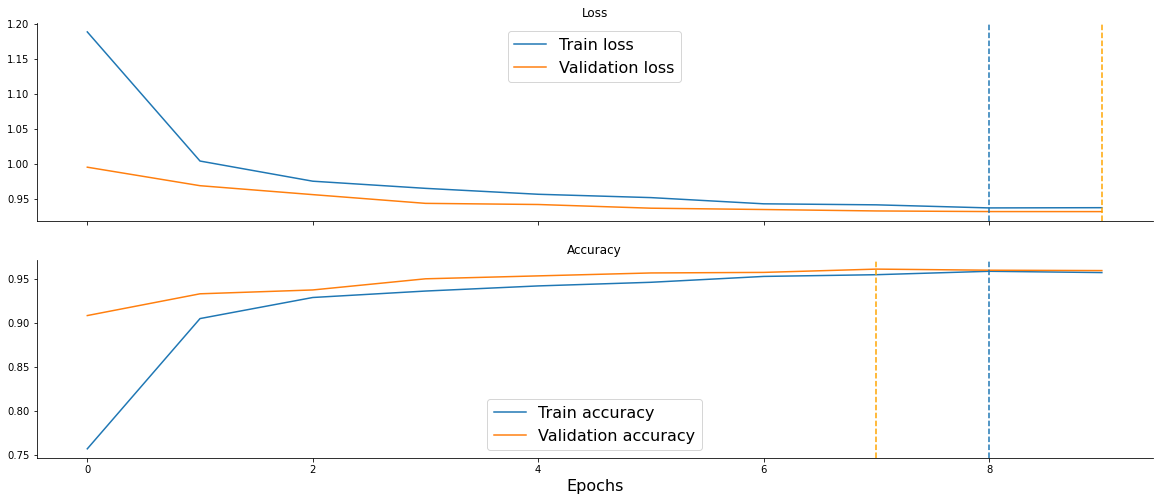


FOLD: 3


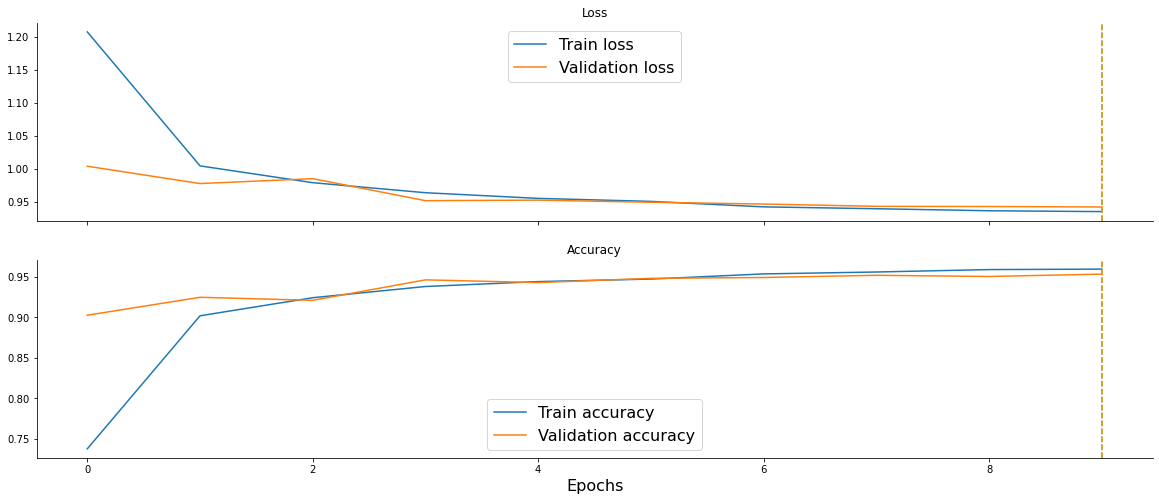


FOLD: 4


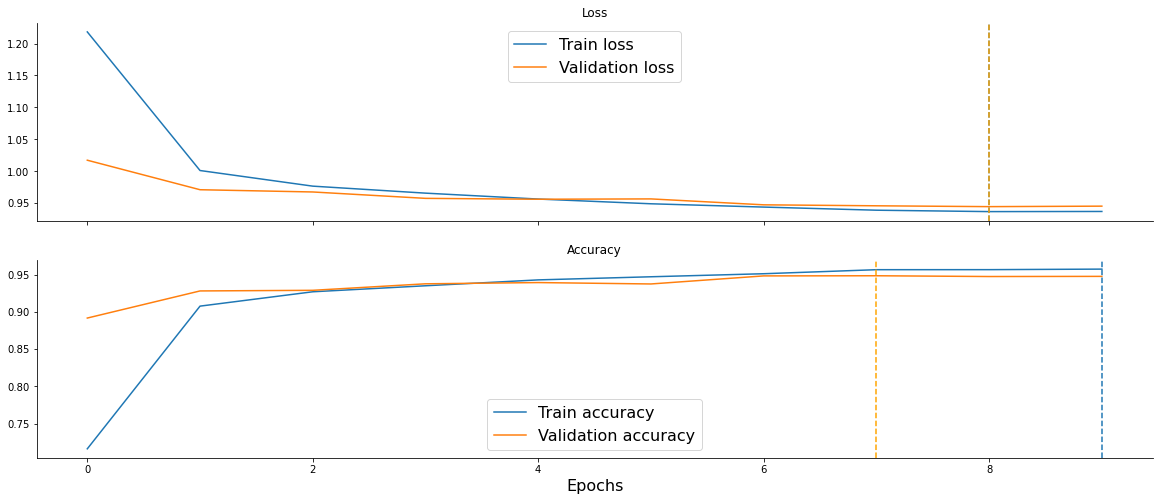


FOLD: 5


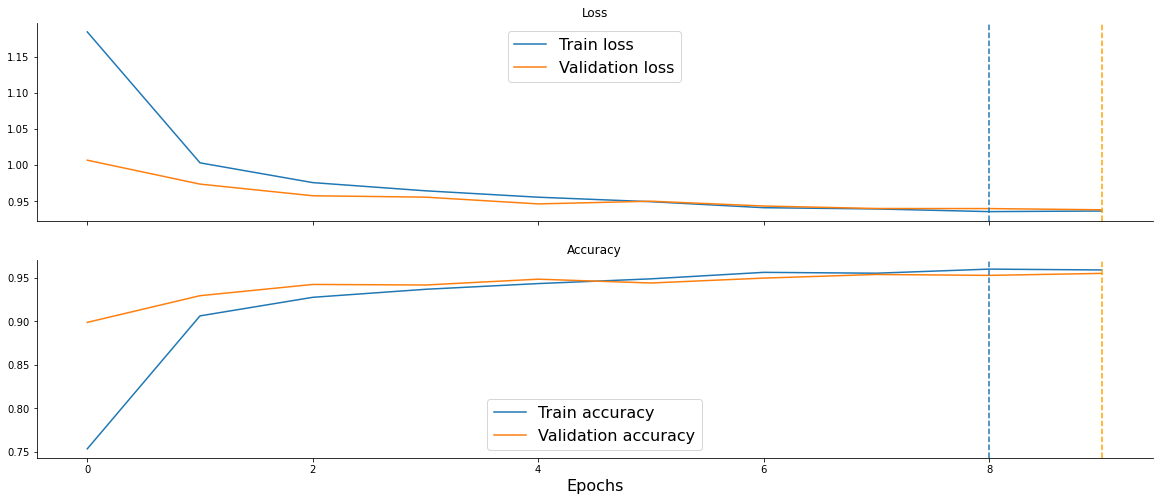

In [15]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

In [16]:
# pred noisy label

noisy_ct = count_data_items(NOISE_FILENAMES)
noisy_preds = np.zeros((noisy_ct, N_CLASSES))
for fold in range(N_FOLDS):
    #if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    with strategy.scope():
        model_path = f'model_{fold}.h5'
        model = model_fn((None, None, CHANNELS), N_CLASSES)

    model.load_weights(model_path)
    print(f'model {model_path} loaded.')
    noisy_ds = get_dataset(NOISE_FILENAMES, labeled=False, ordered=True, repeated=False, augment=False)
    x_oof = noisy_ds.map(lambda image, image_name: image)
    noisy_preds += model.predict(x_oof)

noisy_preds /= 5
print(noisy_preds.shape, noisy_ct)
print(noisy_preds)

model model_0.h5 loaded.
model model_1.h5 loaded.
model model_2.h5 loaded.
model model_3.h5 loaded.
model model_4.h5 loaded.
(2112, 5) 2112
[[0.05795108 0.10797249 0.05738678 0.0752254  0.70146422]
 [0.56221023 0.09589922 0.06029044 0.06554128 0.21605879]
 [0.74288832 0.05842692 0.06579529 0.06851487 0.0643746 ]
 ...
 [0.07656682 0.17052749 0.40988598 0.08346045 0.25955928]
 [0.06956185 0.06235414 0.10757333 0.07735856 0.6831521 ]
 [0.05993116 0.74946733 0.05800313 0.06246989 0.07012843]]


In [17]:
clean_df= pd.read_csv('../input/cassaba-clean-noisy-tfrec/clean_data.csv')
noise_df = pd.read_csv('../input/cassaba-clean-noisy-tfrec/noise_data.csv')
#noise_df['file'] = -1
#display(clean_df)
#display(noise_df)
all_df = pd.concat([clean_df, noise_df], axis=0).reset_index(drop=True)
#display(all_df)

In [18]:
N_FILES=15
folds = StratifiedKFold(n_splits=N_FILES, shuffle=True, random_state=SEED)
all_df['file'] = -1

for fold_n, (train_idx, val_idx) in enumerate(folds.split(all_df, all_df['label'])):
    print('File: %s has %s samples' % (fold_n+1, len(val_idx)))
    all_df['file'].loc[val_idx] = fold_n
    
display(all_df.head())

File: 1 has 1756 samples
File: 2 has 1756 samples
File: 3 has 1756 samples
File: 4 has 1756 samples
File: 5 has 1756 samples
File: 6 has 1756 samples
File: 7 has 1756 samples
File: 8 has 1756 samples
File: 9 has 1756 samples
File: 10 has 1756 samples
File: 11 has 1756 samples
File: 12 has 1756 samples
File: 13 has 1755 samples
File: 14 has 1755 samples
File: 15 has 1755 samples


,image_id,label,source,fold,is_noisy,class,file
0,1000015157.jpg,0,2020,3,False,Cassava Bacterial Blight,7
1,1000201771.jpg,3,2020,2,False,Cassava Mosaic Disease,2
2,1000723321.jpg,1,2020,1,False,Cassava Brown Streak Disease,13
3,1000812911.jpg,3,2020,1,False,Cassava Mosaic Disease,10
4,1000837476.jpg,3,2020,0,False,Cassava Mosaic Disease,3


In [19]:
# noisy label distribution
print(len(noise_df))
all_df.groupby('fold')['is_noisy'].sum()

2112


fold
0    426
1    392
2    458
3    434
4    402
Name: is_noisy, dtype: int64

In [20]:
#noisy_filenames = ['../input/cassaba-clean-noisy-tfrec/Id_noisy00-2112.tfrec']
#noisy_filenames = ['../input/cassaba-clean-noisy-tfrec/Id_noisy00-2112.tfrec']
noisy_ds = get_dataset(NOISE_FILENAMES, labeled=False, ordered=True, repeated=False, augment=False)
noisy_ids = [id.numpy().decode('utf-8') for img, id in iter(noisy_ds.unbatch())]

In [21]:
# noisy_preds = np.random.random((len(noise_df),5))
# noisy_preds.shape

# make pseudo tfrec

In [22]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_list_feature(values):
  """for pseudo label"""
  return tf.train.Feature(float_list=tf.train.FloatList(value=values))

def serialize_example2(image, label, image_name):
  feature = {
      'image': _bytes_feature(image),
      #'label': _int64_feature(label),
      'label': _float_list_feature(label),
      'image_id': _bytes_feature(image_name),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [23]:
# make tfrecord
PATH='../input/cassava-leaf-disease-merged/train/'
IMG_QUALITY = 100
for tfrec_num in range(N_FILES):
    print('\nWriting TFRecord %i of %i...'%(tfrec_num, N_FILES))
    samples = all_df[all_df['file'] == tfrec_num]
    n_samples = len(samples)
    print(f'{n_samples} samples')
    with tf.io.TFRecordWriter('Id_train%.2i-%i.tfrec'%(tfrec_num, n_samples)) as writer:
        for row in samples.itertuples():
            image_name = row.image_id
            label = row.label

            if image_name in noise_df['image_id']:
                # use pseudo label
                index = noisy_ids.index(image_name)
                ohehot_label = noisy_preds[index]
            else:                
                onehot_label = [0]*N_CLASSES
                onehot_label[label]+=1.0

            img_path = f'{PATH}{image_name}'            
            img = cv2.imread(img_path)
            img = cv2.resize(img, (HEIGHT, WIDTH))
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, IMG_QUALITY))[1].tostring()
            
            example = serialize_example2(img, onehot_label, str.encode(image_name))
            writer.write(example)
            
all_df.to_csv('all_data.csv', index=False)


Writing TFRecord 0 of 15...
1756 samples

Writing TFRecord 1 of 15...
1756 samples

Writing TFRecord 2 of 15...
1756 samples

Writing TFRecord 3 of 15...
1756 samples

Writing TFRecord 4 of 15...
1756 samples

Writing TFRecord 5 of 15...
1756 samples

Writing TFRecord 6 of 15...
1756 samples

Writing TFRecord 7 of 15...
1756 samples

Writing TFRecord 8 of 15...
1756 samples

Writing TFRecord 9 of 15...
1756 samples

Writing TFRecord 10 of 15...
1756 samples

Writing TFRecord 11 of 15...
1756 samples

Writing TFRecord 12 of 15...
1755 samples

Writing TFRecord 13 of 15...
1755 samples

Writing TFRecord 14 of 15...
1755 samples


In [24]:
#noisy_ids
pseudo_df = pd.DataFrame({'image_id':noisy_ids})
pseudo_df['pseudo_labels'] = list(map(lambda x: str(x), noisy_preds))
pseudo_df.to_csv('pseudo_label.csv', index=False)

In [25]:
import glob
def read_tfrecord2(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'label': tf.io.FixedLenFeature([5], tf.float32), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_id': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = example['label']
        print(label_or_name)
        # One-Hot Encoding needed to use "categorical_crossentropy" loss
        #label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), N_CLASSES)
    else:
        label_or_name = example['image_id']
    return image, label_or_name


def get_dataset2(FILENAMES, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(FILENAMES)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord2(x, labeled=labeled), num_parallel_calls=AUTO)
    
#     if augment:
#         dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
#     dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
#     dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
#     if not ordered:
#         dataset = dataset.shuffle(2048)
#     if repeated:
#         dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    
    # cutmix
#     if augment:
#         dataset = dataset.map(partial(cutmix, proba=CUTMIX_PROB), num_parallel_calls=AUTO)

#     if cached:
#         dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

#filenames = glob.glob('./*.tfrec')
#ds = get_dataset2(filenames, labeled=True, ordered=False, repeated=True, augment=True)

In [26]:
#for data, label in iter(ds.unbatch()):
#    print(data.shape)
#    print(label)
#    break